In [1]:
import os
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point

In [2]:
polys = c.kenya_counties_msSimplified
keep_flds = ['County', 'CID']
os.path.isfile(polys)

True

In [3]:
admin = gpd.read_file(polys).to_crs({'init': 'epsg:4326'}).sort_values(by='CID').reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
admin.head(3)

,County,CID,geom_poly
0,MOMBASA,1,(POLYGON ((39.57004987900007 -3.99129018799993...
1,KWALE,2,POLYGON ((39.08651450795459 -3.569310636452954...
2,KILIFI,3,"POLYGON ((40.01240101900004 -3.35857645699997,..."


In [4]:
def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    return gdf_dissolve.set_geometry('geom_exterior')

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))
admin.head(3)

,County,CID,geom_poly,geom_centroid,geom_convexhull
0,MOMBASA,1,(POLYGON ((39.57004987900007 -3.99129018799993...,POINT (39.66231840170038 -4.003225497243148),POLYGON ((39.64316800000006 -4.151179999999954...
1,KWALE,2,POLYGON ((39.08651450795459 -3.569310636452954...,POINT (39.14645868037131 -4.143656557862073),POLYGON ((39.20529000000005 -4.676006665999978...
2,KILIFI,3,"POLYGON ((40.01240101900004 -3.35857645699997,...",POINT (39.68213748242578 -3.176025391462719),POLYGON ((39.54412026300002 -3.993630653999958...


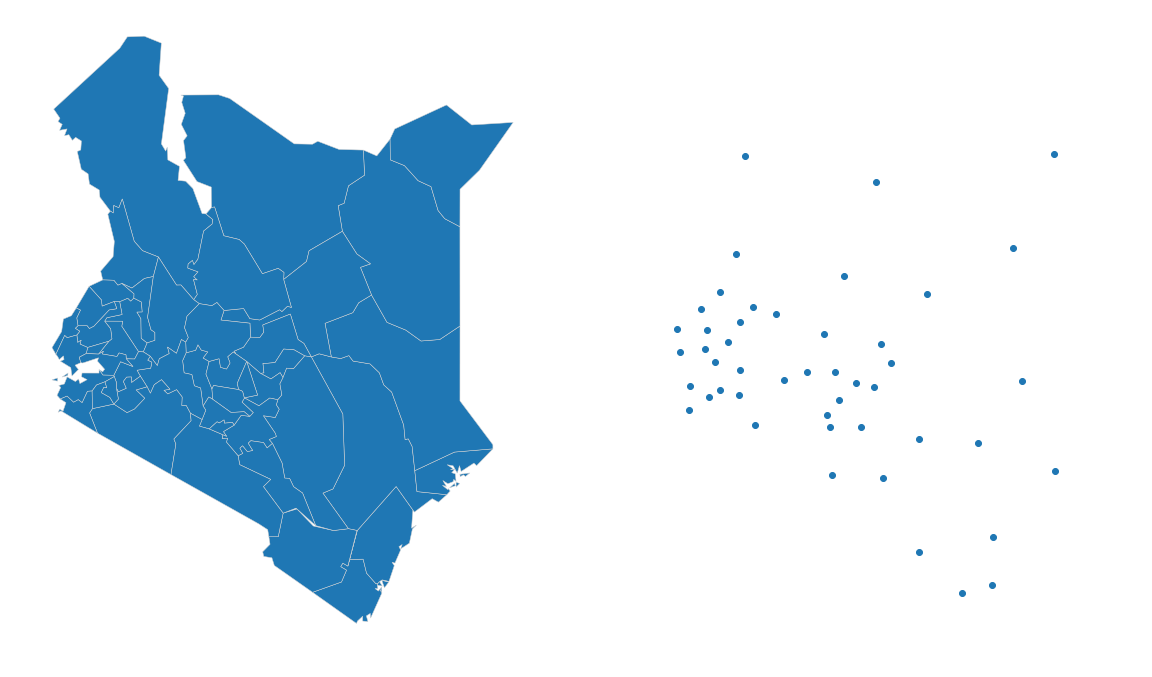

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin.set_geometry('geom_centroid').plot(ax=ax2)

plt.show()

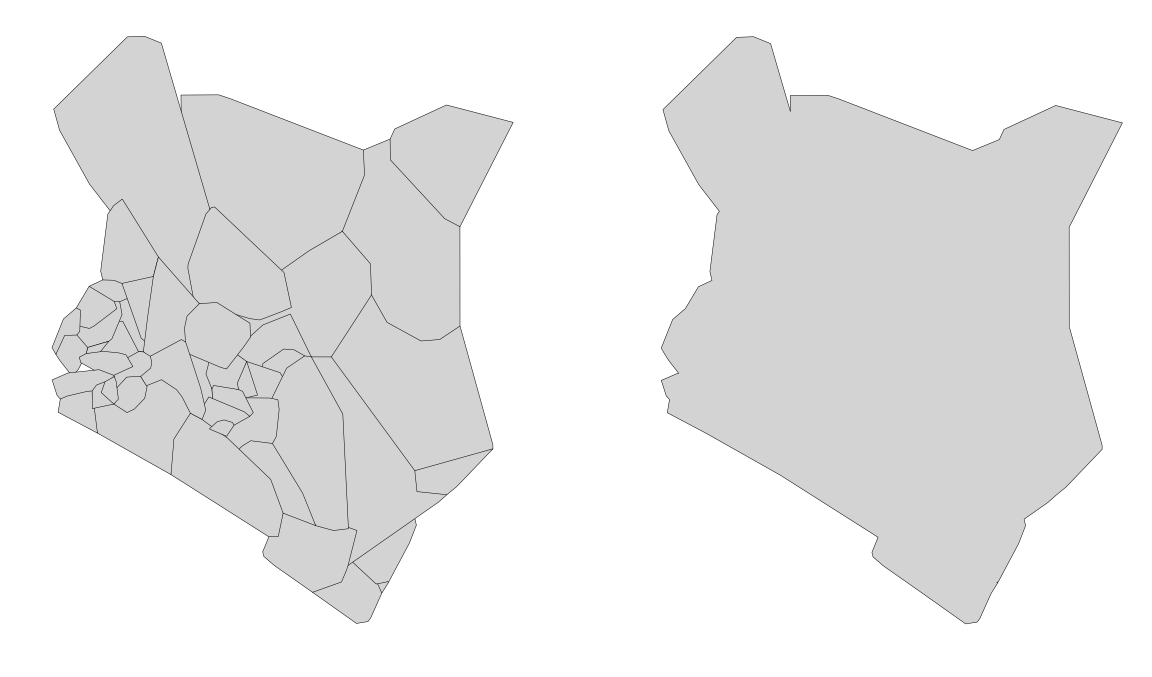

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')

plt.show()

In [7]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': 33.944107056,
 'miny': -4.676006666,
 'maxx': 41.912158183,
 'maxy': 5.470517919,
 'rangex': 7.968051127,
 'rangey': 10.146524585}

In [20]:
def displace_point(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_point(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    return pts
        
def tesselate_hexagons(x, y, length, flat='up'):
    hexes = []
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt = 3
    elif flat=='side':
        bearing = 0
        next_start_pt = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    for x in range(0,5):
        try:
            start_x = hexagon[next_start_pt][0]
            start_y = hexagon[next_start_pt][1]
            hexagon = build_hexagon(start_x, start_y, length, bearing)
        except:
            hexagon = build_hexagon(bbox['minx'], bbox['miny'], length, bearing)

        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [Polygon(hexagon)]}), geometry='geom_poly')
        hex_gdf = add_centroid_geom(hex_gdf)
        hexes += [hex_gdf]
    print(type(hexes))
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    print(len(hexes_gdf))
    return hexes_gdf
    
    
hexagons = tesselate_hexagons(bbox['minx'], bbox['miny'], length=.5, flat='up')
#pt = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Point(hexagons[start_pt])]}), geometry='geometry', crs=admin.crs)
hexagons

<class 'list'>
5


,geom_poly,geom_centroid
0,"POLYGON ((33.944107056 -4.676006666, 34.194107...",POINT (34.44410705601728 -4.676006665997506)
1,POLYGON ((34.94410705602592 -4.676006665955104...,POINT (35.4441070560432 -4.67600666595261)
2,POLYGON ((35.94410705605184 -4.676006665910207...,POINT (36.44410705606913 -4.676006665907714)
3,POLYGON ((36.94410705607776 -4.676006665865311...,POINT (37.44410705609505 -4.676006665862817)
4,POLYGON ((37.94410705610368 -4.676006665820414...,POINT (38.44410705612096 -4.67600666581792)


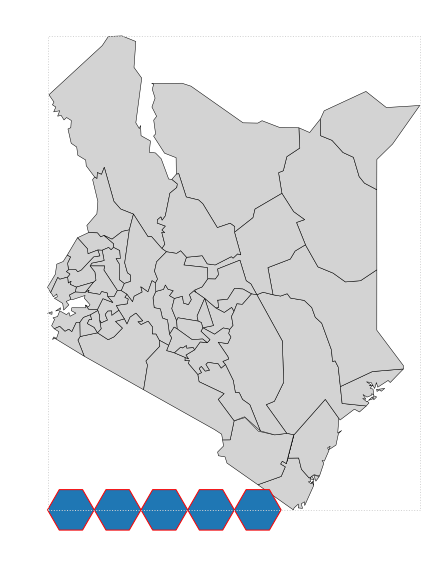

In [21]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')
hexagons.plot(ax=ax1, edgecolor='red')
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
#pt.plot(ax=ax1, color='red')
plt.show()